In [1]:
import pandas as pd
#import requests 
#from io import StringIO
#from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
import geopandas as gpd
#from shapely import ops
from shapely import geometry as geom
import os
import urllib
#from sjoin import sjoin
%matplotlib inline

### 1. Get map data for Queens

In [2]:
# map data for NYC
zipgeojson = "https://github.com/YuHuaCheng/Map/raw/master/data/nyc-zip-code-tabulation-areas-polygons.geojson"

# save the NYC map data under "data" folder
zipsfile = os.path.join("data",zipgeojson.split("/")[-1])

# read the saved NYC map data file
try:
    NZ = gpd.read_file(zipsfile) # NYC map data with Zipcode
except OSError as e:
    urllib.request.urlretrieve(zipgeojson, zipsfile)
    
    #zips geojson had a var assignment that caused problems
    fin      = open(zipsfile)
    
    lines    = [line for line in fin]
    lines[0] = lines[0].replace("var nycdata = ", "")
    
    fin.close()
    
    fout = open(zipsfile, "w")
    for line in lines:
        fout.write(line)
    fout.flush()
    fout.close()
    
    NZ = gpd.read_file(zipsfile)
    
NZ.shape # NYC is composed of 262 subarea on the map data

(262, 12)

In [6]:
# NYC map data with Zipcode
#NZ.head(3)

In [7]:
# draw the map data for New York City
#NZ.plot(figsize=(14,7))
#plt.title("The Geography of New York City")
#plt.xlabel("longitude")
#plt.ylabel("latitude")

In [3]:
# seperate Queens map data from NYC map data
QN = NZ[NZ.borough=='Queens']
QN = QN.reset_index()

In [4]:
QN.head(3)

,index,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode
0,0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040


In [5]:
# number of different zipcodes in Queens
print("number of zip codes in Queens: ", QN.postalCode.unique().shape[0]) # 67

# number of shape areas in QN data
#print("number of shape areas in Queens: ", QN.Shape_Area.unique().shape[0]) # 70

number of zip codes in Queens:  67


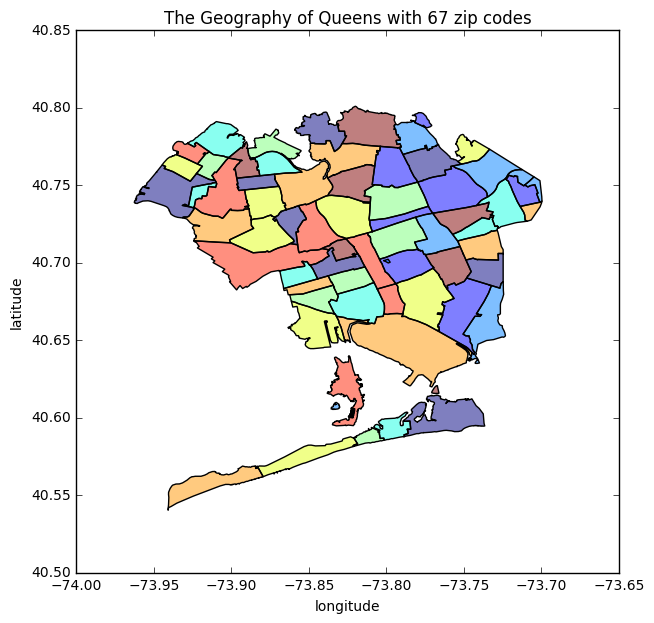

In [6]:
# draw Queens
QN.plot(figsize=(14,7))
#plt.title("The Geography of Queens with 70 Sub Area") # <~~~~~~~~~~~~~~ editted it for each shape doesn't mean zip
plt.title("The Geography of Queens with 67 zip codes")
plt.xlabel("longitude")
plt.ylabel("latitude")

### 2. Apply taxi data into Queens map data
**1) Read preprocessed taxi dataset.**

In [7]:
# read stored csv files
taxi_data_10 = pd.read_csv("taxi_data_csv_files/taxi_data_10.csv")
taxi_data_11 = pd.read_csv("taxi_data_csv_files/taxi_data_11.csv")
taxi_data_12 = pd.read_csv("taxi_data_csv_files/taxi_data_12.csv")
taxi_data_13 = pd.read_csv("taxi_data_csv_files/taxi_data_13.csv")
taxi_data_14 = pd.read_csv("taxi_data_csv_files/taxi_data_14.csv")

In [17]:
taxi_data_10.head(1)

,Unnamed: 0,dropoff_latitude,dropoff_longitude,dropoff_datetime,pickup_datetime,pickup_latitude,pickup_longitude,tip_amount,trip_distance
0,0,40.749413,-73.985765,2010-10-05T02:19:00.000,NaN,40.759252,-73.973838,3.0,1.46


**2) Process taxi data to make it applicable to map data.**

In [9]:
# from taxi data, take pickup & dropoff latitude and longitude pairs
# transform the pair into points and return the points
def cov_latlon_POINT(dataframe): 
    
    pickup_latlon = []
    dropoff_latlon = [] #dropoff
    
    for i in range (len(dataframe)):
        
        pickup_latlon.append(geom.Point(dataframe.pickup_longitude.iloc[i],
                                        dataframe.pickup_latitude.iloc[i]))
        
        dropoff_latlon.append(geom.Point(dataframe.dropoff_longitude.iloc[i], #dropoff
                                        dataframe.dropoff_latitude.iloc[i]))
    # pickup   
    PickupP_df      = gpd.GeoSeries(pickup_latlon)
    PickupP_df      = PickupP_df[PickupP_df.values != 'POINT (0.0 0.0)'] #get rid of 0.0 0.0 lon-lat points
    #GeoPickup_Point = gpd.GeoDataFrame(geometry=PickupP_df)
    
    # dropoff
    DropoffP_df     = gpd.GeoSeries(dropoff_latlon) 
    DropoffP_df     = DropoffP_df[DropoffP_df.values != 'POINT (0.0 0.0)'] 
    
    # concatenate the two data frames
    TripP_df        = pd.concat([PickupP_df, DropoffP_df])
    
    GeoPickup_Point = gpd.GeoDataFrame(geometry=TripP_df)
    
    return (GeoPickup_Point)

In [ ]:
# get trip points(= pickup + dropoff) for each years

# 2010 trip points
GeoTrip10 = cov_latlon_POINT(taxi_data_10)

# 2011 trip points
GeoTrip11 = cov_latlon_POINT(taxi_data_11)

# 2012 trip points
GeoTrip12 = cov_latlon_POINT(taxi_data_12)

# 2013 trip points
GeoTrip13 = cov_latlon_POINT(taxi_data_13)

# 2014 trip points
GeoTrip14 = cov_latlon_POINT(taxi_data_14)

In [16]:
# confirm the trip points
year = 2010
for trip_data in [GeoTrip10, GeoTrip11, GeoTrip12, GeoTrip13, GeoTrip14]:
    print(year, "trip points:", trip_data.shape)
    print("First two points in the trip points:")
    print(trip_data.head(2))
    print("-----------------------------------")
    year = year + 1

2010 trip points: (200000, 1)
First two points in the trip points:
                       geometry
0  POINT (-73.973838 40.759252)
1   POINT (-73.96821 40.770695)
-----------------------------------
2011 trip points: (200000, 1)
First two points in the trip points:
                               geometry
0  POINT (-73.98677499999999 40.725802)
1          POINT (-73.993387 40.721605)
-----------------------------------
2012 trip points: (200000, 1)
First two points in the trip points:
                               geometry
0  POINT (-73.89217499999999 40.746992)
1          POINT (-73.782115 40.644622)
-----------------------------------
2013 trip points: (200000, 1)
First two points in the trip points:
                      geometry
0   POINT (-73.994935 40.7348)
1  POINT (-73.972595 40.76223)
-----------------------------------
2014 trip points: (200000, 1)
First two points in the trip points:
                               geometry
0  POINT (-73.97773000000001 40.752252)
1          P

** 3) Apply the trip points into Queens map. **

In [57]:
# take point data and map data, and return a list of the point lists within the geometry of the map data
def points_in_region(points, region): # <~~~~~~~~~~~~~~ editted it from "City_only_Points(GeoP)"
    within_region = []
    for i in range(len(region)):
        point_in_sub_area = points[points.geometry.within(region.geometry[i])]
        within_region.append(point_in_sub_area) 
    return(within_region)

In [20]:
# get trip points in Queens for each year #<~~~~~~~~~~this takes long time
trip_in_QN10 = points_in_region(GeoTrip10, QN)

In [21]:
trip_in_QN11 = points_in_region(GeoTrip11, QN)

In [22]:
trip_in_QN12 = points_in_region(GeoTrip12, QN)

In [23]:
trip_in_QN13 = points_in_region(GeoTrip13, QN)

In [24]:
trip_in_QN14 = points_in_region(GeoTrip14, QN)

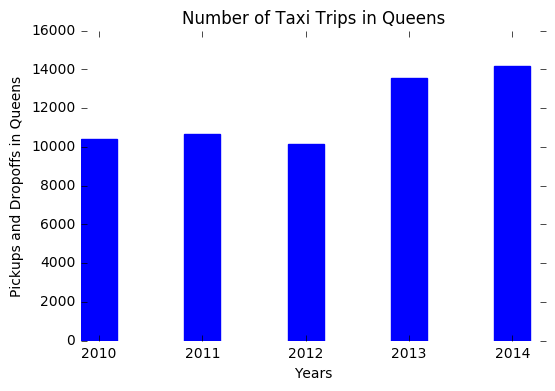

In [26]:
# get sum of the trip points in each zip code area
def get_trip_sum(geo_points):
    sum_  = 0
    for i in range (len(geo_points)):
        sum_ = sum_ + len(geo_points[i])
    return sum_

# the number of taxi trips in Queens
sum_trip10 = get_trip_sum(trip_in_QN10)
sum_trip11 = get_trip_sum(trip_in_QN11)
sum_trip12 = get_trip_sum(trip_in_QN12)
sum_trip13 = get_trip_sum(trip_in_QN13)
sum_trip14 = get_trip_sum(trip_in_QN14)

# bar graph - the number of taxi trips in Queens
fig = plt.figure()
ax = fig.add_subplot(111)

ind = np.arange(5) # the x locations for the groups
width = 0.35       # the width of the bars

y_val = [sum_trip10, sum_trip11, sum_trip12, sum_trip13, sum_trip14]
p1 = ax.bar(ind, y_val, width, edgecolor='b')

ax.set_frame_on(False)

ax.set_title('Number of Taxi Trips in Queens')
ax.set_xlabel('Years')
ax.set_ylabel('Pickups and Dropoffs in Queens')

ax.set_xticks(ind + width/2.)
ax.set_xticklabels(('2010', '2011', '2012', '2013', '2014'))

** 4) Apply the trip points into sub area - zip codes - in Queens. **

In [58]:
# get sum of the trips in the sub-region
def get_trip_sum_local(geo_points):
    sums  = []
    for i in range (len(geo_points)):
        sums.append(len(geo_points[i]))
    return sums

# the number of taxi trips in subarea of Queens
loc_sum_trip10 = get_trip_sum_local(trip_in_QN10)
loc_sum_trip11 = get_trip_sum_local(trip_in_QN11)
loc_sum_trip12 = get_trip_sum_local(trip_in_QN12)
loc_sum_trip13 = get_trip_sum_local(trip_in_QN13)
loc_sum_trip14 = get_trip_sum_local(trip_in_QN14)
#len(loc_sum_trip10) # 70 for each sub area

In [122]:
# create a dataframe
df_tripQN = pd.DataFrame({'zip_code':QN.postalCode,
                          'trip_10':loc_sum_trip10,
                          'trip_11':loc_sum_trip11,
                          'trip_12':loc_sum_trip12,
                          'trip_13':loc_sum_trip13,
                          'trip_14':loc_sum_trip14})
df_tripQN.head()

,trip_10,trip_11,trip_12,trip_13,trip_14,zip_code
0,120,167,142,391,468,11372
1,0,7,0,1,0,11004
2,2,0,0,1,0,11040
3,6,8,4,7,5,11426
4,33,20,24,33,37,11365


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f374cd76860>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f374cbc3198>]], dtype=object)

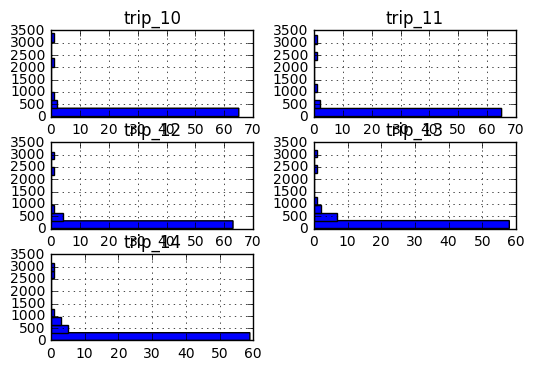

In [94]:
#df_tripQN.index
#df_tripQN.trip_10
df_tripQN.hist(orientation='horizontal') # <========================================= try 1

In [123]:
# draw a bar graph                   # <========================================= try 2
fig = plt.figure()
ax = fig.add_subplot(111)

ind = np.arange(70)  # the x locations for the groups
#width = 0.3             # the width of the bars

#x_val = df_tripQN.index
y_val = df_tripQN.trip_10
p1 = ax.barh(y_val, ind, align='center', edgecolor='b')

ax.set_frame_on(False)

ax.set_title('Number of Taxi Trips in Subarea of Queens')
ax.set_xlabel('Zip Codes')
ax.set_ylabel('Pickups and Dropoffs in Queens')

ax.set_xticks(ind)
ax.set_xticklabels(df_tripQN.zip_code)

#plt.xticks(rotate=90)
#plt.xticks(rotation='vertical')

AttributeError: 'BarContainer' object has no attribute 'figure'

** 5) Gentrification suspected area with statistical method. **

In [77]:
# suspect the area where taxi trip increased drastically 
# between 2010 and 2014 as a gentrification area

# gentrification suspected area in Queens
gen_susp_area_series = df_tripQN.iloc[:,0:4].transpose().describe().loc['std', :].sort_values(ascending=False)
#print(gen_susp_area_series.head(4))

gen_susp_area = gen_susp_area_series.head(4).keys()
print(gen_susp_area)

Int64Index([7, 43, 40, 5], dtype='int64')


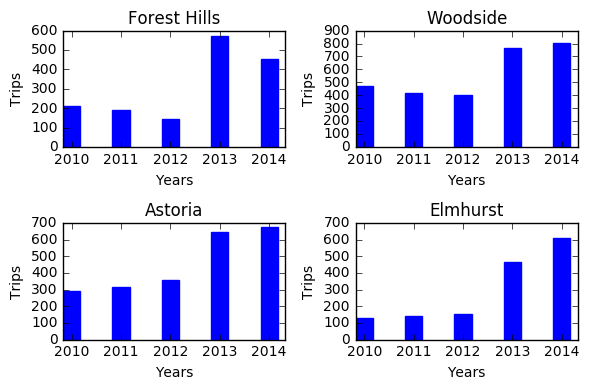

In [88]:
# bar graph - the number of taxi pickups in Queens
ind = np.arange(5) # the x locations for the groups
width = 0.35       # the width of the bars

fig = plt.figure()

def get_y(sub_area_num):
    y_val = [loc_sum_trip10[sub_area_num], 
             loc_sum_trip11[sub_area_num], 
             loc_sum_trip12[sub_area_num], 
             loc_sum_trip13[sub_area_num], 
             loc_sum_trip14[sub_area_num]]
    return y_val

#for area in gen_susp_area:   
ax1 = fig.add_subplot(221)
ax1.bar(ind, get_y(gen_susp_area[0]), width, edgecolor='b')
ax1.set_title(QN.PO_NAME.iloc[gen_susp_area[0]])
ax1.set_xlabel('Years')
ax1.set_ylabel('Trips')
ax1.set_xticks(ind + width/2.)
ax1.set_xticklabels(('2010', '2011', '2012', '2013', '2014'))

ax2 = fig.add_subplot(222)
ax2.bar(ind, get_y(gen_susp_area[1]), width, edgecolor='b')
ax2.set_title(QN.PO_NAME.iloc[gen_susp_area[1]])
ax2.set_xlabel('Years')
ax2.set_ylabel('Trips')
ax2.set_xticks(ind + width/2.)
ax2.set_xticklabels(('2010', '2011', '2012', '2013', '2014'))

ax3 = fig.add_subplot(223)
ax3.bar(ind, get_y(gen_susp_area[2]), width, edgecolor='b')
ax3.set_title(QN.PO_NAME.iloc[gen_susp_area[2]])
ax3.set_xlabel('Years')
ax3.set_ylabel('Trips')
ax3.set_xticks(ind + width/2.)
ax3.set_xticklabels(('2010', '2011', '2012', '2013', '2014'))

ax4 = fig.add_subplot(224)
ax4.bar(ind, get_y(gen_susp_area[3]), width, edgecolor='b')
ax4.set_title(QN.PO_NAME.iloc[gen_susp_area[3]])
ax4.set_xlabel('Years')
ax4.set_ylabel('Trips')
ax4.set_xticks(ind + width/2.)
ax4.set_xticklabels(('2010', '2011', '2012', '2013', '2014'))

plt.tight_layout()

As an example, taxi trips in Forest Hills and Elmhurst increased drastically between 2012 and 2013.
We suspect gentrification happened in Forest Hills and Elmhurst between 2012 and 2013.

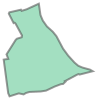

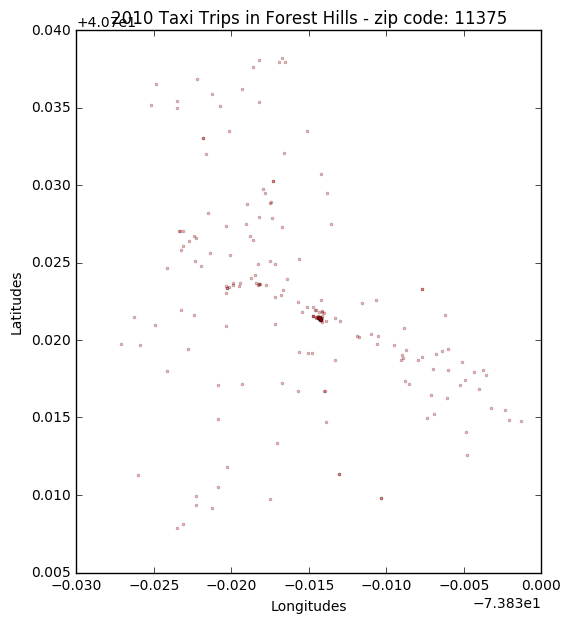

In [101]:
# visualize Forest Hills trips 
# 2010
ForestHills10 = GeoTrip10[GeoTrip10.geometry.within(QN.geometry[gen_susp_area[0]])]
ForestHills10.plot(marker='o', color='red', alpha=0.3, markersize=2, figsize=(14,7))
plt.title("2010 Taxi Trips in " + QN.PO_NAME.iloc[gen_susp_area[0]] + 
          " - zip code: " + str(QN.postalCode.iloc[gen_susp_area[0]]))
plt.xlabel("Longitudes")
plt.ylabel("Latitudes")
QN.geometry[gen_susp_area[0]]

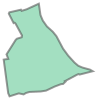

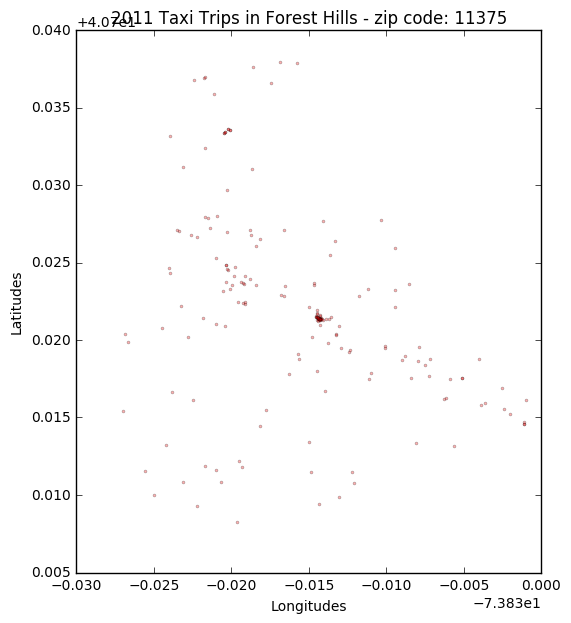

In [102]:
# 2011
ForestHills11 = GeoTrip11[GeoTrip11.geometry.within(QN.geometry[gen_susp_area[0]])]
ForestHills11.plot(marker='o', color='red', alpha=0.3, markersize=2, figsize=(14,7))
plt.title("2011 Taxi Trips in " + QN.PO_NAME.iloc[gen_susp_area[0]] + " - zip code: " + str(QN.postalCode.iloc[gen_susp_area[0]]))
plt.xlabel("Longitudes")
plt.ylabel("Latitudes")
QN.geometry[gen_susp_area[0]]

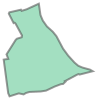

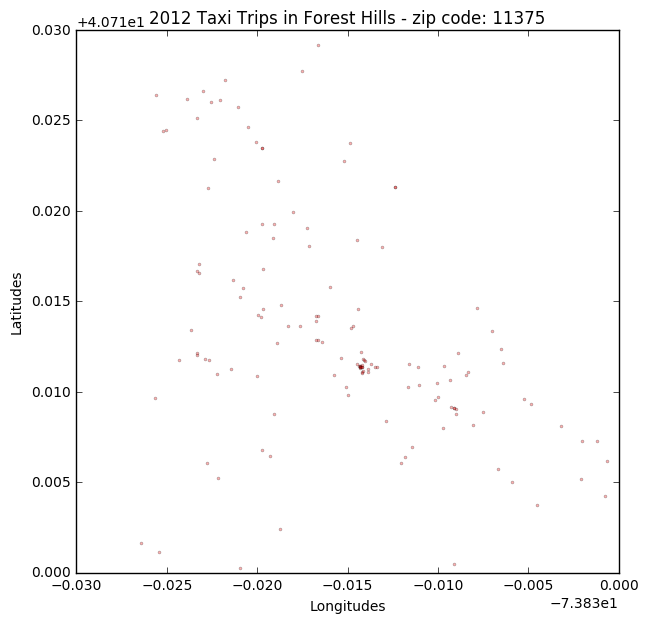

In [103]:
# 2012
ForestHills12 = GeoTrip12[GeoTrip12.geometry.within(QN.geometry[gen_susp_area[0]])]
ForestHills12.plot(marker='o', color='red', alpha=0.3, markersize=2, figsize=(14,7))
plt.title("2012 Taxi Trips in " + QN.PO_NAME.iloc[gen_susp_area[0]] + " - zip code: " + str(QN.postalCode.iloc[gen_susp_area[0]]))
plt.xlabel("Longitudes")
plt.ylabel("Latitudes")
QN.geometry[gen_susp_area[0]]

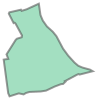

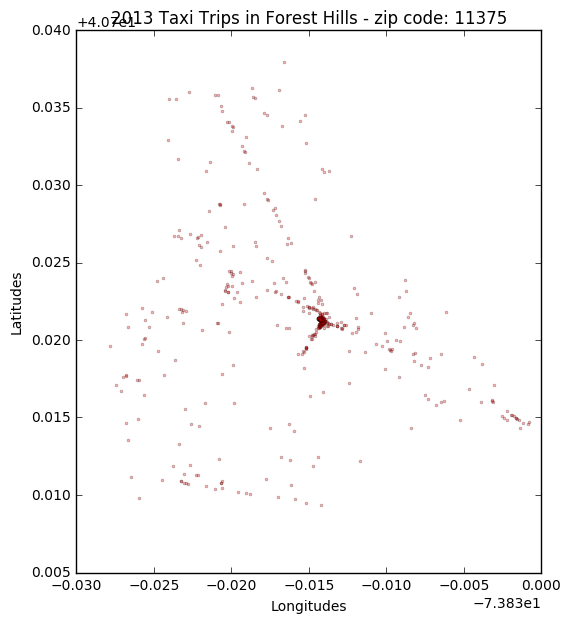

In [104]:
# 2013
ForestHills13 = GeoTrip13[GeoTrip13.geometry.within(QN.geometry[gen_susp_area[0]])]
ForestHills13.plot(marker='o', color='red', alpha=0.3, markersize=2, figsize=(14,7))
plt.title("2013 Taxi Trips in " + QN.PO_NAME.iloc[gen_susp_area[0]] + " - zip code: " + str(QN.postalCode.iloc[gen_susp_area[0]]))
plt.xlabel("Longitudes")
plt.ylabel("Latitudes")
QN.geometry[gen_susp_area[0]]

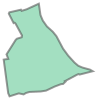

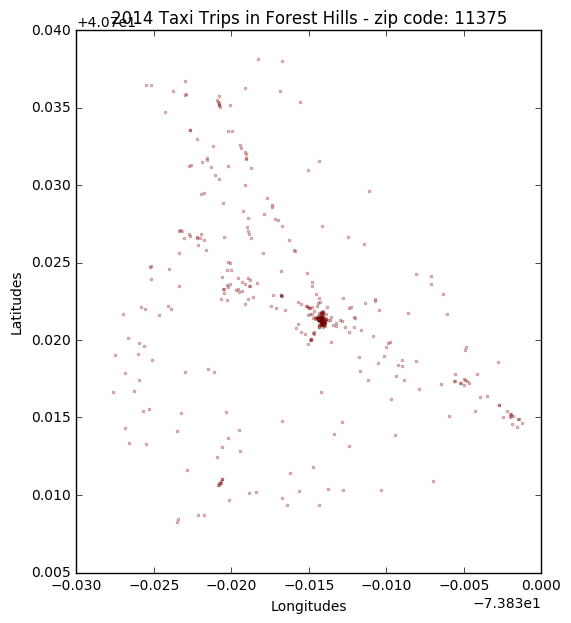

In [106]:
# 2014
ForestHills14 = GeoTrip14[GeoTrip14.geometry.within(QN.geometry[gen_susp_area[0]])]
ForestHills14.plot(marker='o', color='red', alpha=0.3, markersize=2, figsize=(14,7))
plt.title("2014 Taxi Trips in " + QN.PO_NAME.iloc[gen_susp_area[0]] + " - zip code: " + str(QN.postalCode.iloc[gen_susp_area[0]]))
plt.xlabel("Longitudes")
plt.ylabel("Latitudes")
QN.geometry[gen_susp_area[0]]

**6) visualize trips in subarea of Queens where the most trips happened.**

In [107]:
# sort the pickup points for each subarea in Queens based on zip code
def sort_points(points):
    points_per_zipcode = {}
    for i in range(len(points)):
        points_per_zipcode[i] = len(points[i])
    return points_per_zipcode

In [108]:
# sort pickup points for each year
trip_per_zipcode10 = sort_points(trip_in_QN10)
trip_per_zipcode11 = sort_points(trip_in_QN11)
trip_per_zipcode12 = sort_points(trip_in_QN12)
trip_per_zipcode13 = sort_points(trip_in_QN13)
trip_per_zipcode14 = sort_points(trip_in_QN14)

In [109]:
# make a dataframe for pickup points per zip code in Queens
QN_per_Zip_df10 = pd.DataFrame.from_dict(trip_per_zipcode10, orient='index')
QN_per_Zip_df10.rename(columns={0: 'trips'}, inplace = True)
QN_per_Zip_df10['ZIP'] = QN.postalCode.values
QN_per_Zip_df10.head()

,trips,ZIP
0,120,11372
1,0,11004
2,2,11040
3,6,11426
4,33,11365


In [111]:
# sort the pickup data in decending order based on number of pickups
max_trip = QN_per_Zip_df10.sort_values('trips', ascending = False)
max_trip.head()

,trips,ZIP
31,3388,11371
60,2352,11430
45,938,11101
43,471,11377
41,462,11106


In [115]:
# find the area with max trips
max_val = max_trip.reset_index()
print ("The max trips made per Zip-Code is: ", max_val.loc[0]['trips'])
print ("The ZipCode that it Corresponds to is: ", max_val.loc[0].ZIP)
print("The area is", QN.PO_NAME.iloc[31])

The max trips made per Zip-Code is:  3388
The ZipCode that it Corresponds to is:  11371
The area is Flushing


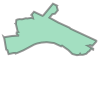

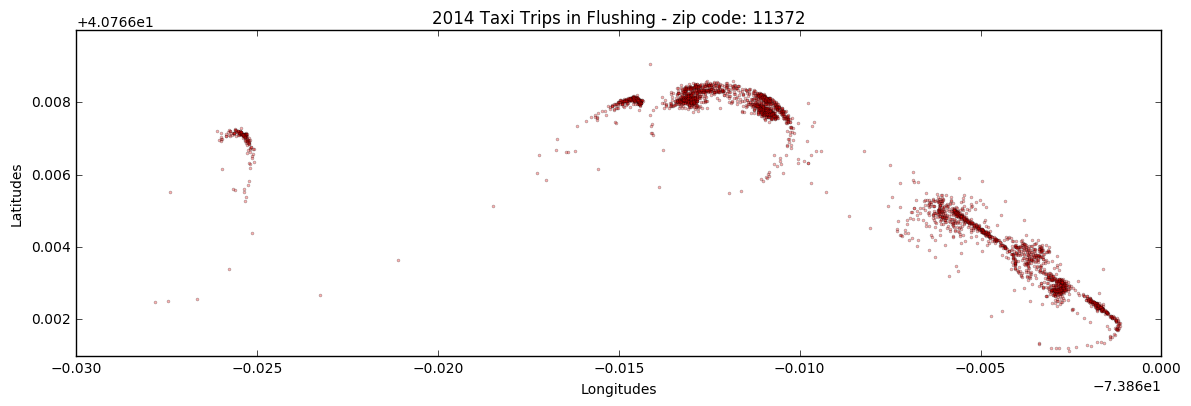

In [113]:
# visualize flushing pickups 
Plot_11371 = GeoTrip14[GeoTrip14.geometry.within(QN.geometry[31])]
QN.geometry[31]
Plot_11371.plot(marker='o', color='red', alpha=0.3, markersize=2, figsize=(14,7))
plt.title("2014 Taxi Trips in " + QN.PO_NAME.iloc[31] + " - zip code: " + str(max_trip.ZIP[0]))
plt.xlabel("Longitudes")
plt.ylabel("Latitudes")
QN.geometry[31]